In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# Load data
df = pd.read_excel('/Users/mrina/Downloads/careeronestop_data.xlsx')

# Clean data
df.drop(["job_link"], axis=1, inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

# Tokenize and lemmatize job descriptions
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    words = word_tokenize(text.lower())
    words = [w for w in words if w.isalpha() and w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return " ".join(words)

df["description_cleaned"] = df["description"].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mrina\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mrina\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mrina\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Topic modeling using LDA
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
doc_word = vectorizer.fit_transform(df["description_cleaned"])

# Define search parameters
search_params = {'n_components': [5, 10, 15, 20], 'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation()

# Perform grid search
lda_model = GridSearchCV(lda, param_grid=search_params)
lda_model.fit(doc_word)

# Best model
best_lda_model = lda_model.best_estimator_

# Print best parameters
print("Best parameters:", lda_model.best_params_)

# Print log likelihood score
print("Log likelihood score:", lda_model.best_score_)

Best parameters: {'learning_decay': 0.5, 'n_components': 15}
Log likelihood score: -1622771.6331548728


In [3]:
# Visualize topics
n_topics = lda_model.best_params_['n_components']
top_n_words = 10
feature_names = vectorizer.get_feature_names()
topic_keywords = []
for topic_weights in best_lda_model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:top_n_words]
    topic_keywords.append([feature_names[i] for i in top_keyword_locs])
    
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ["Word " + str(i) for i in range(1, top_n_words+1)]
df_topic_keywords.index = ["Topic " + str(i) for i in range(1, n_topics+1)]
print(df_topic_keywords)

                 Word 1         Word 2         Word 3         Word 4  \
Topic 1        security          cyber  vulnerability     experience   
Topic 2       skyepoint  cybersecurity       security  vulnerability   
Topic 3   cybersecurity       security    engineering         design   
Topic 4        maryland            usa           http            job   
Topic 5        security     experience     technology          cloud   
Topic 6   cybersecurity      technical        digital    requirement   
Topic 7        forensic     technology     experience          cyber   
Topic 8        security    information      architect     management   
Topic 9             hay  cybersecurity     management    information   
Topic 10       security       solution   architecture     enterprise   
Topic 11       security        testing          skill           work   
Topic 12            iam       security   architecture       solution   
Topic 13  cybersecurity       security     experience        sup

C:\Users\mrina\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [4]:
# Visualize topic weights
doc_topic = best_lda_model.transform(doc_word)
df_topic_weights = pd.DataFrame(doc_topic)
df_topic_weights.columns = ["Topic " + str(i) for i in range(1, n_topics+1)]
df_topic_weights["Dominant Topic"] = df_topic_weights.idxmax(axis=1)
df_topic_weights["Job Title"] = df["job_title"]
df_topic_weights["Description"] = df["description_cleaned"]
print(df_topic_weights.head())

    Topic 1   Topic 2   Topic 3   Topic 4   Topic 5   Topic 6   Topic 7  \
0  0.051630  0.000143  0.066333  0.000143  0.084488  0.000143  0.006403   
1  0.000168  0.069925  0.069358  0.000168  0.052231  0.049808  0.036201   
2  0.007241  0.146171  0.028604  0.000072  0.053128  0.050484  0.025031   
3  0.000383  0.114133  0.000383  0.000383  0.000383  0.000383  0.000383   
4  0.069536  0.053682  0.000160  0.003807  0.051252  0.118906  0.027356   

    Topic 8   Topic 9  Topic 10  Topic 11  Topic 12  Topic 13  Topic 14  \
0  0.049516  0.191210  0.025796  0.057311  0.034739  0.136799  0.295202   
1  0.041046  0.161761  0.016460  0.308920  0.131014  0.050301  0.012473   
2  0.028137  0.510988  0.000072  0.043760  0.079992  0.000072  0.026174   
3  0.076120  0.461405  0.000383  0.173035  0.171475  0.000383  0.000383   
4  0.363906  0.131081  0.000160  0.000160  0.063578  0.028945  0.000160   

   Topic 15 Dominant Topic                                          Job Title  \
0  0.000143      

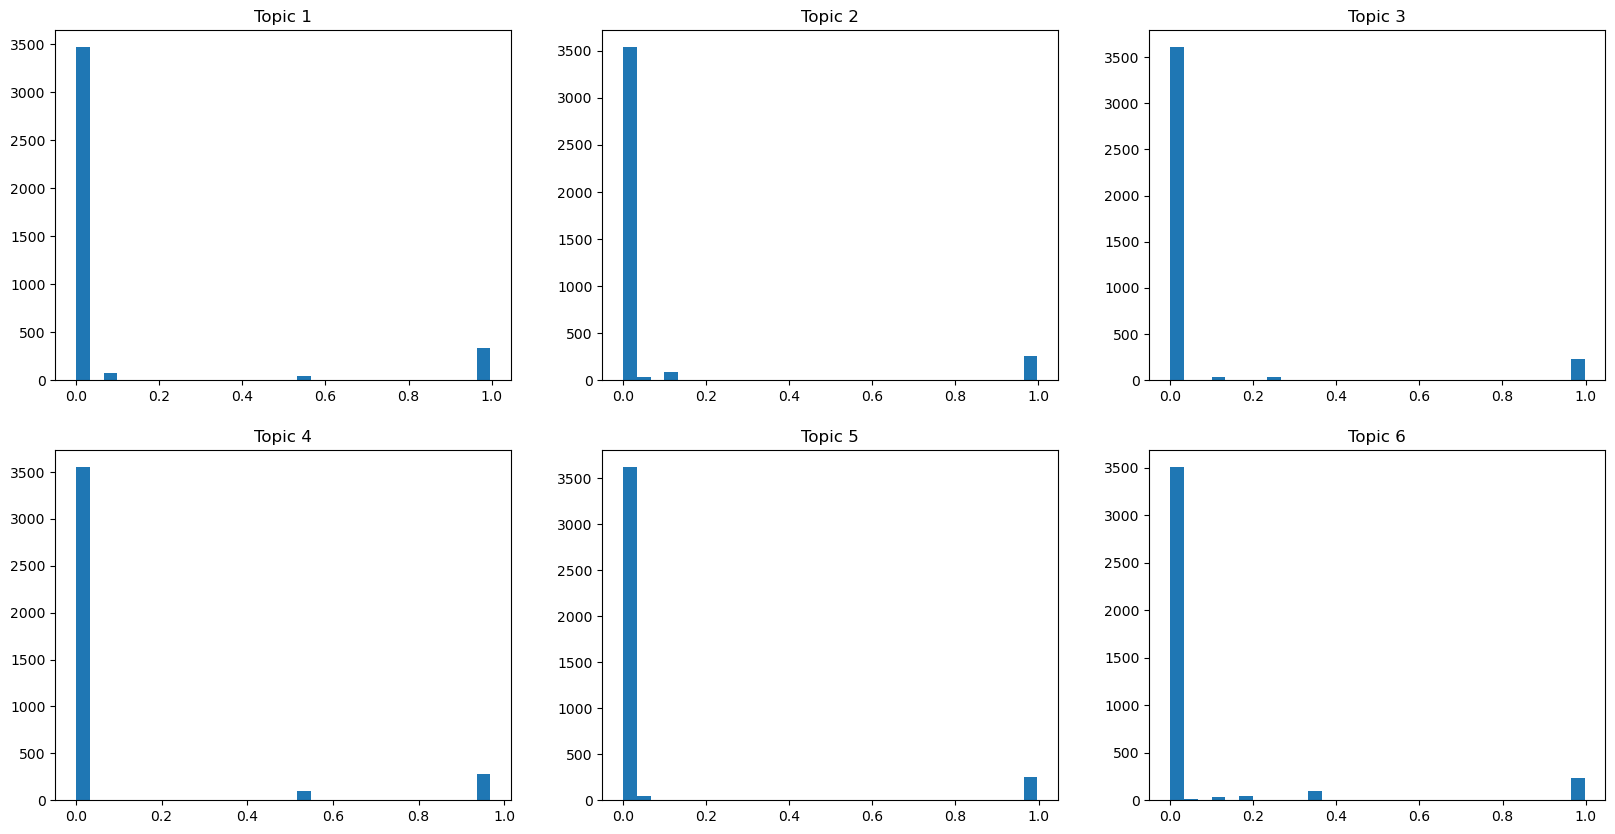

In [5]:
# Plot histogram of topic weights
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
for i, ax in enumerate(axes.flatten()):
    if i < n_topics:
        ax.hist(df_topic_weights["Topic " + str(i+1)], bins=30)
        ax.set_title("Topic " + str(i+1))

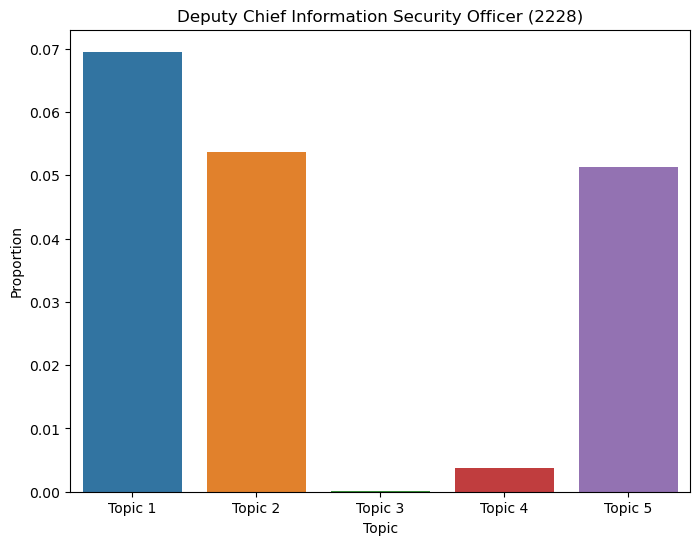

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the job title and relevant columns
job_title = df['job_title'].iloc[5]
job_df = df_topic_weights[df_topic_weights['Job Title'] == job_title][['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5']]

# Calculate the proportion of job postings in each topic
job_df_prop = job_df.mean()

# Plot the proportions as a bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=job_df_prop.index, y=job_df_prop.values)
plt.title(job_title)
plt.ylabel('Proportion')
plt.xlabel('Topic')
plt.show()

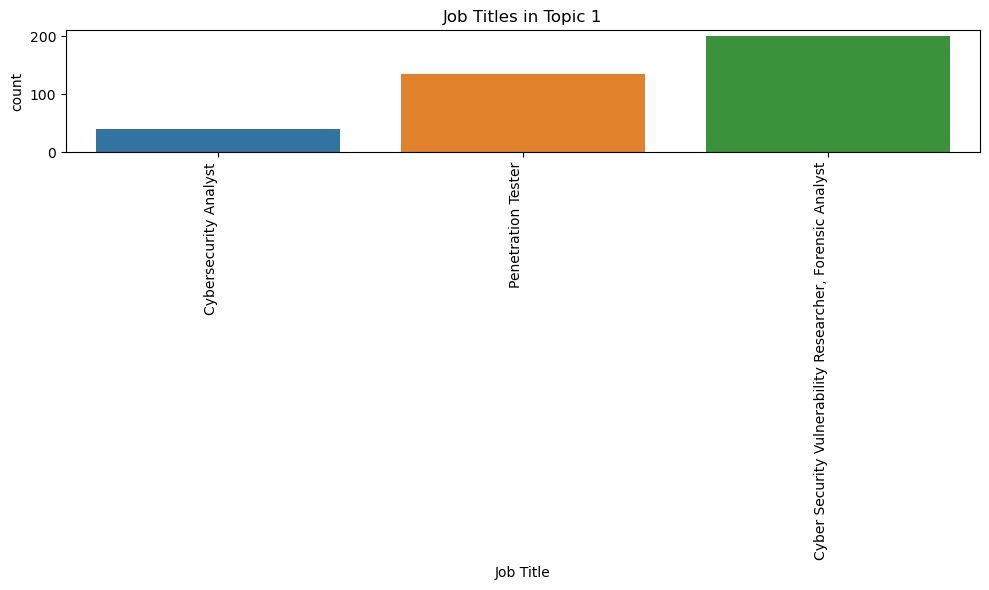

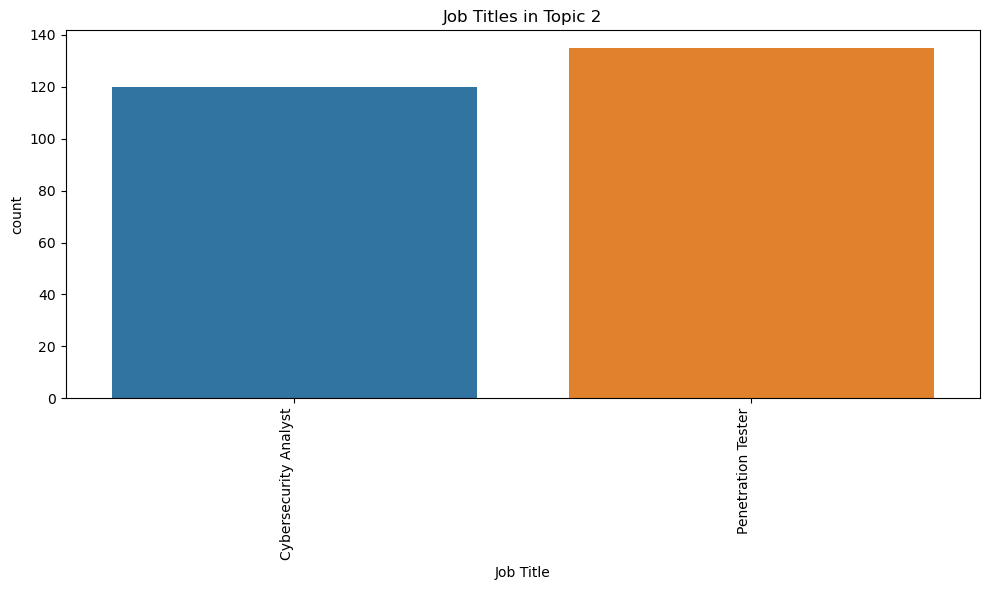

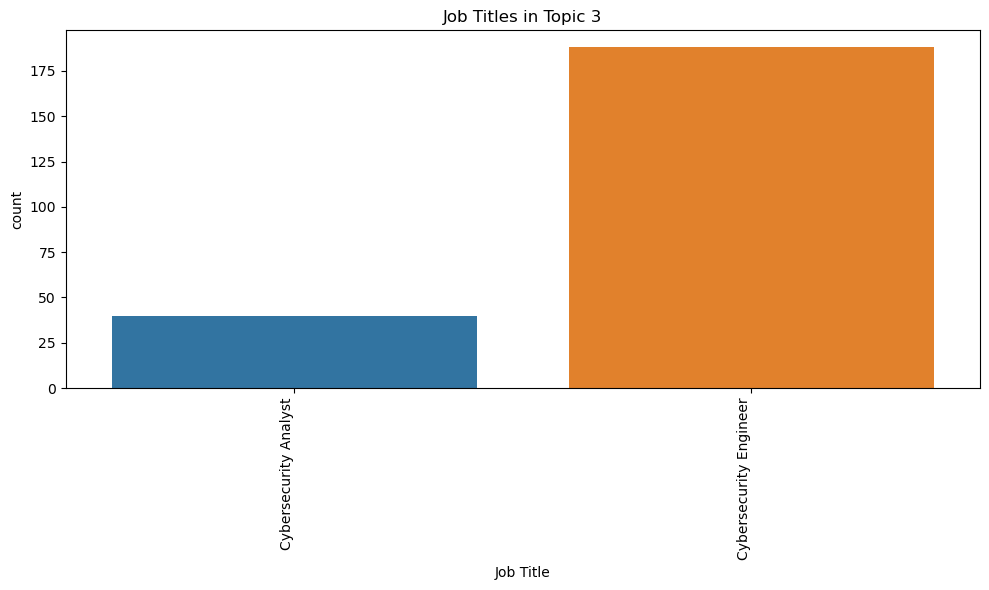

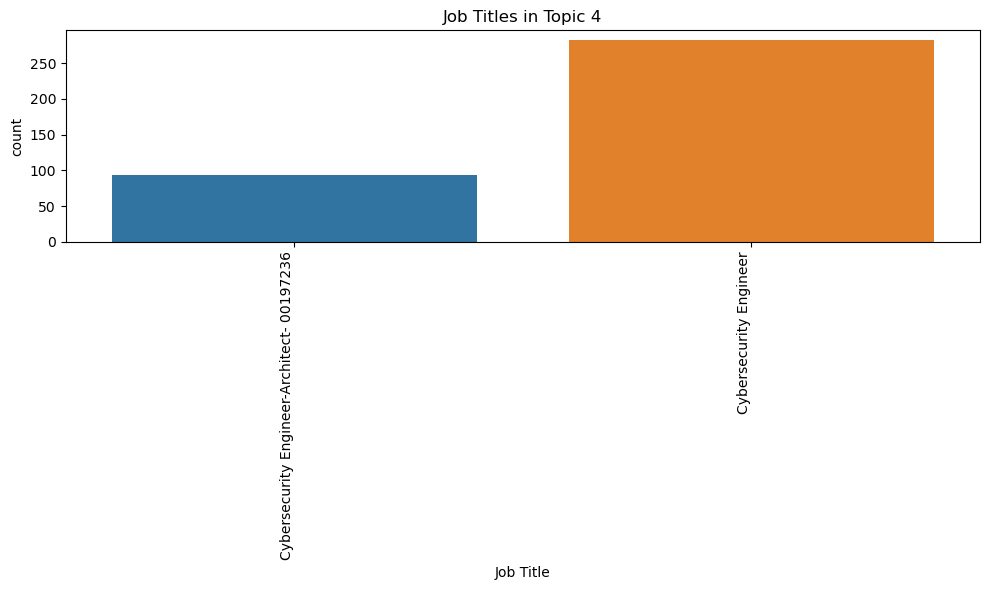

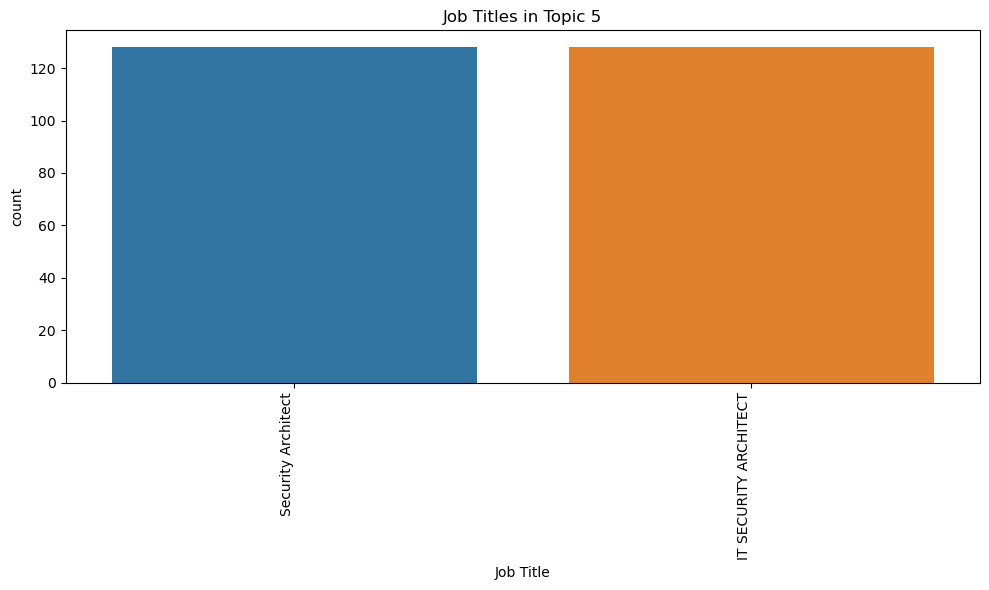

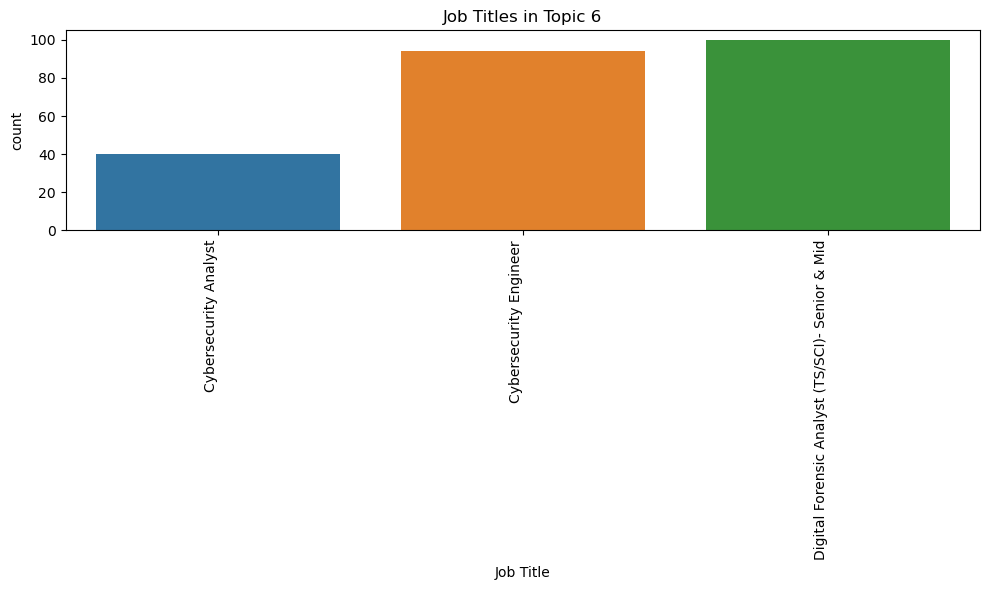

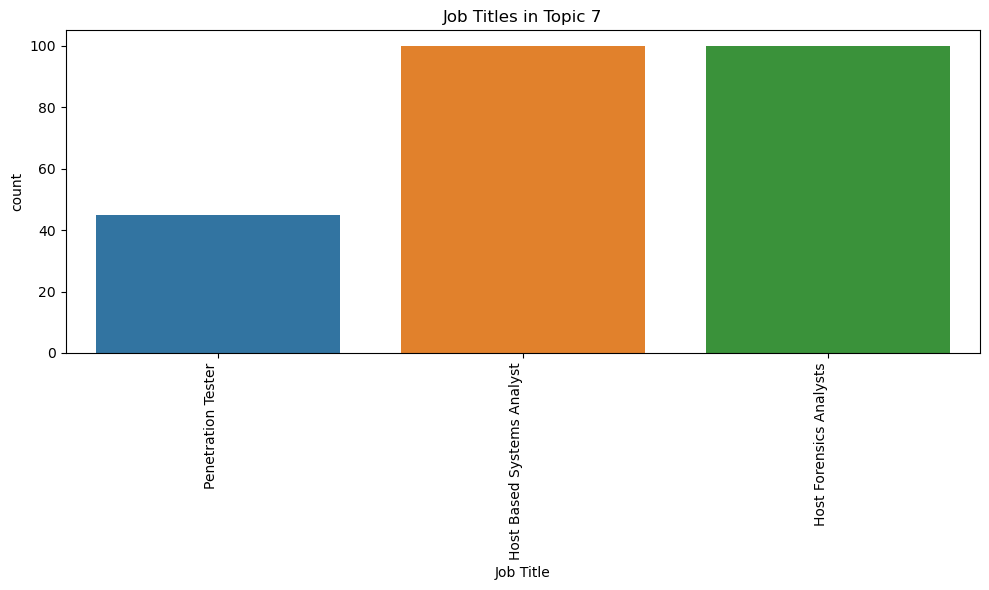

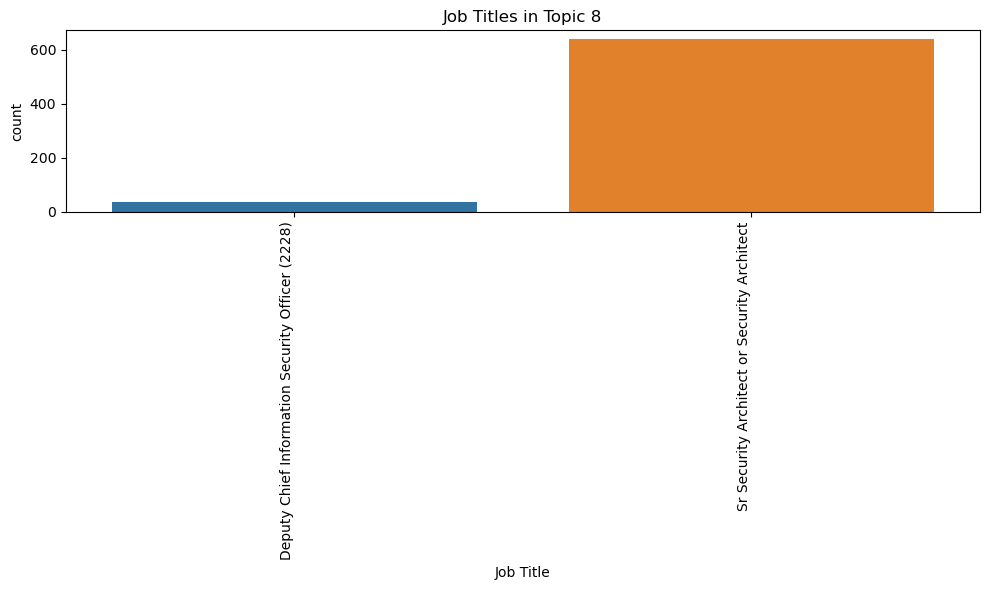

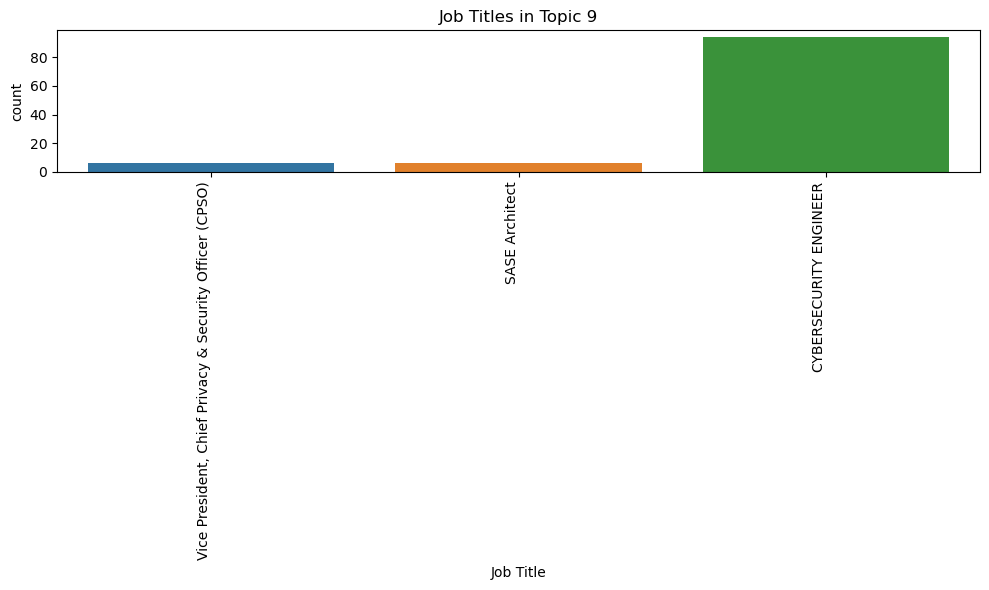

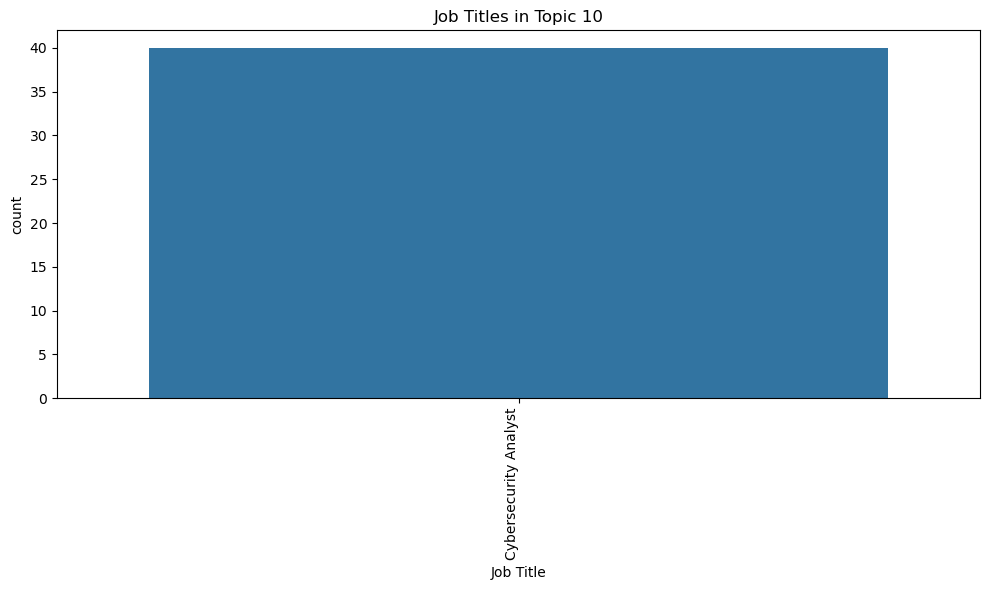

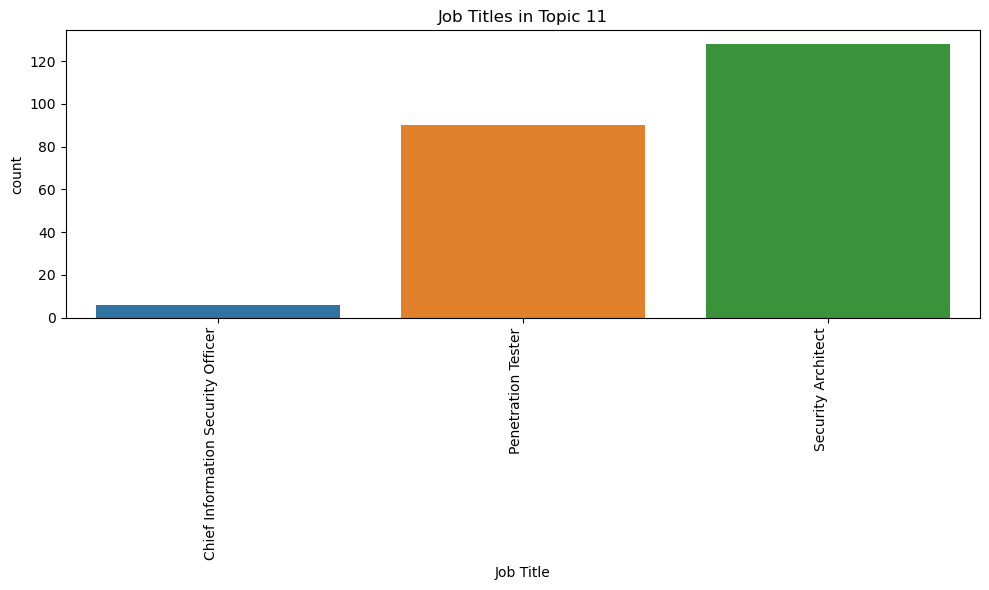

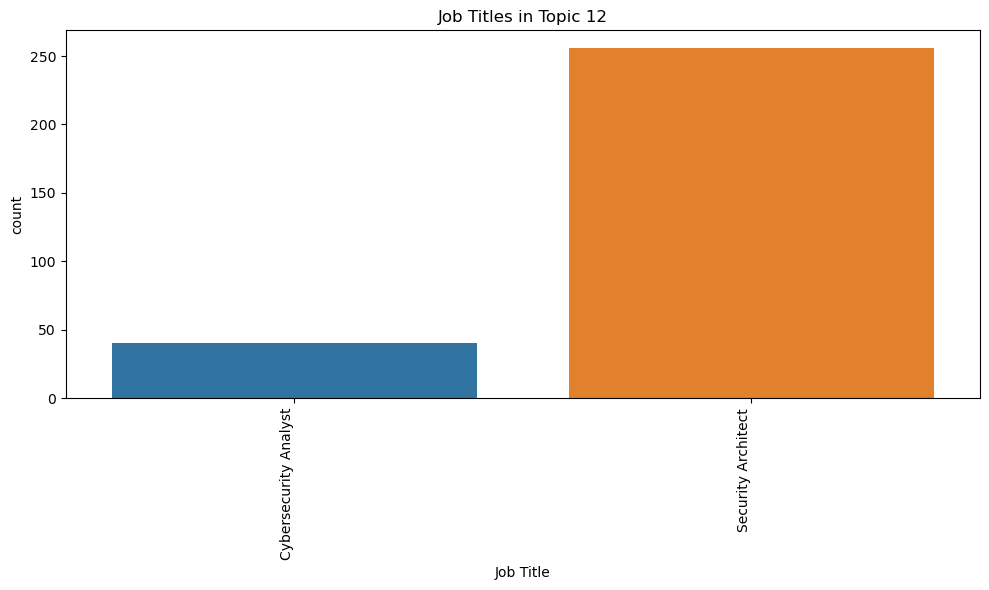

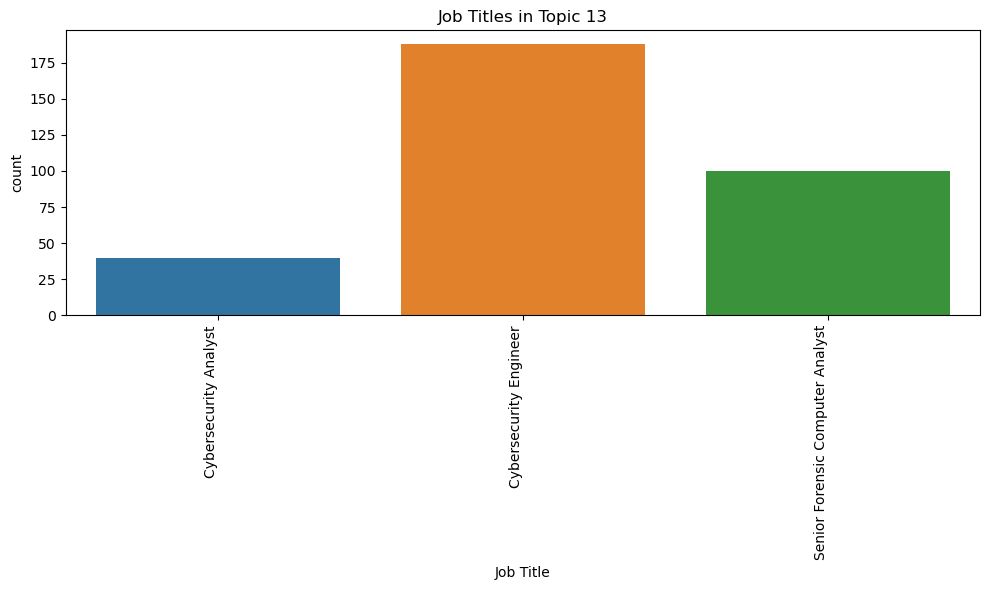

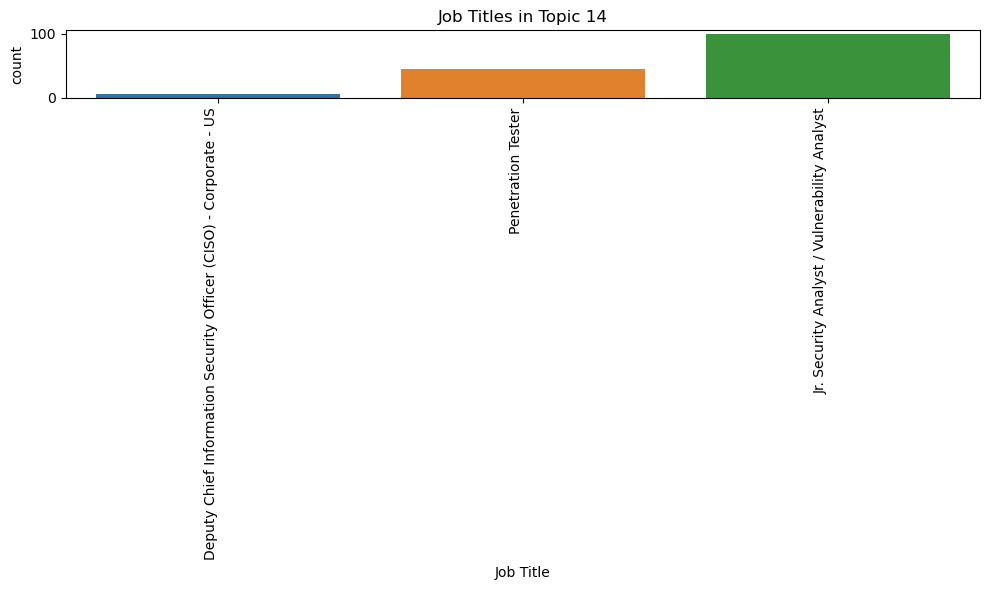

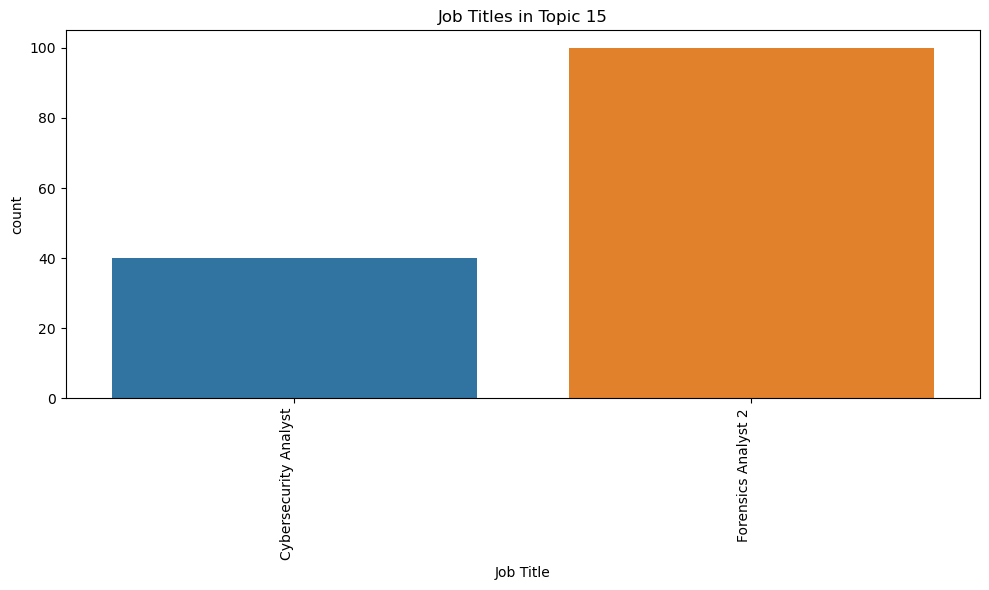

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Iterate over each topic
for i in range(n_topics):
    # Filter the dataframe to only include rows where the dominant topic is the current topic
    df_topic_i = df_topic_weights[df_topic_weights["Dominant Topic"] == "Topic " + str(i+1)]
    
    # Plot a bar chart of the count of job titles in this topic
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.countplot(x="Job Title", data=df_topic_i, ax=ax)
    ax.set_title("Job Titles in Topic " + str(i+1))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
    plt.tight_layout()
    plt.show()